In [1]:
import numpy as np
from UAV import *
import random
from sklearn.manifold import MDS
import matplotlib.pyplot as plt           # for plotting

### Definition of the Distance Matrix

In [2]:
n_robots = 3#int(input("number of robots: "))
platoon = []

c_set = ['black'] + ['green' for i in range(1,n_robots)]

# initialization of n robots
for i in range(n_robots):
    i_robot = Robot("op_" + str(i),random.uniform(0, 10.0),random.uniform(0, 10.0),0)
    platoon.append(i_robot)

coordinates = [[],[],[]]

for rob in platoon:
    coordinates = np.append(coordinates,rob.get_coords(),axis=1)

S = coordinates[0:2,:]

DM  = d_matrix(platoon)
DM2 = d_matrix2(platoon)
print(DM)
print(DM2)

[[0.         9.2859369  6.98529601]
 [9.2859369  0.         4.34769007]
 [6.98529601 4.34769007 0.        ]]
[[ 0.         86.22862408 48.79436036]
 [86.22862408  0.         18.9024089 ]
 [48.79436036 18.9024089   0.        ]]


### Identity matrix

In [3]:
I   = np.eye(n_robots)
print(I)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


### Definition of the e vector and the H matrix

In [4]:
e   = np.array([[1] for i in range(n_robots)])

H = I - (e*e.T)/n_robots
print(H)

[[ 0.66666667 -0.33333333 -0.33333333]
 [-0.33333333  0.66666667 -0.33333333]
 [-0.33333333 -0.33333333  0.66666667]]


### Eigendecomposition of the matrix -1/2HDH

In [5]:
print(-1/2*H*DM*H,'\n')

#Eigenvalues ev, eigenvectors EV
ev,EV = np.linalg.eig(-1/2*H*DM*H)

#Lambda is the diagonal matrix whose elements are the eigenvalues
LAMBDA = np.eye(n_robots)*ev

#U is the matrix whose columns are the eigenvectors
U      = np.transpose(EV)
print(LAMBDA,'\n\n',U)

#Sstar  = np.sqrt(LAMBDA).transpose(U)
#print(Sstar)

[[-0.         -0.51588538 -0.388072  ]
 [-0.51588538 -0.         -0.24153834]
 [-0.388072   -0.24153834 -0.        ]] 

[[-0.77455772  0.          0.        ]
 [-0.          0.5457832   0.        ]
 [-0.          0.          0.22877452]] 

 [[-0.63940122 -0.58240086 -0.50197143]
 [-0.75650024  0.59318809  0.27538205]
 [-0.13738073 -0.55582113  0.81987158]]


### Scikit learn MDS approach

In [6]:
n_components = 2                                   # p, reduced dimensionality space
embedding = MDS(n_components=2,
                n_init = 50,
                max_iter = 10000,
                eps=1e-5,
                dissimilarity='precomputed') # instantiate and set the hyperparameter
                
Sstar = embedding.fit_transform(DM).T

print(Sstar)
print(S)

[[-0.91807496  2.46077206 -1.54269711]
 [ 5.2022213  -3.44834973 -1.75387157]]
[[0.69285865 8.42088378 4.16954007]
 [2.50523026 7.65365251 8.56386432]]


#### Plot

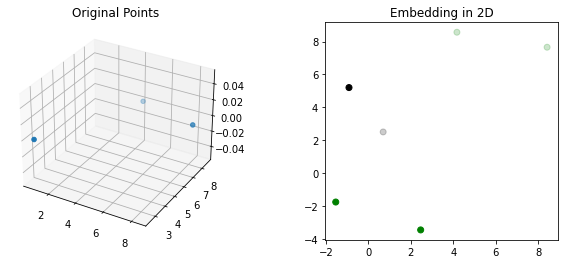

In [7]:
fig = plt.figure(2, (10,4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter3D(coordinates[0,:], coordinates[1,:], coordinates[2,:])
plt.title('Original Points')

ax = fig.add_subplot(122)
plt.scatter(Sstar[0,:], Sstar[1,:], color=c_set, alpha=1.0)
plt.scatter(S    [0,:], S    [1,:], color=c_set, alpha=0.2)
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

### Introduction of the controlled displacement

In [29]:
deltaX = deltaY = 0.1

deltaSprime = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
deltaSprime[:,0] = [deltaX,deltaY]
print(deltaSprime)


[[0.1 0.  0. ]
 [0.1 0.  0. ]]


ValueError: operands could not be broadcast together with shapes (2,) (2,3) 

In [9]:
Sprime = S + deltaSprime
print(Sprime)

[[0.79285865 8.42088378 4.16954007]
 [2.60523026 7.65365251 8.56386432]]


### DM' definition

In [10]:
DMprime = DM_from_S(Sprime,verbose=1)

Phi':
 [[  7.41584954]
 [129.48968033]
 [ 90.72483645]]
DM' :
 [[ 0.         83.67333461 46.90729727]
 [83.67333461  0.         18.9024089 ]
 [46.90729727 18.9024089   0.        ]]


Let's have a look at the distance matrices. They are pretty similar, since the displacement is very small. GOOD

In [11]:
print(DMprime)
print(DM2)

[[ 0.         83.67333461 46.90729727]
 [83.67333461  0.         18.9024089 ]
 [46.90729727 18.9024089   0.        ]]
[[ 0.         86.22862408 48.79436036]
 [86.22862408  0.         18.9024089 ]
 [48.79436036 18.9024089   0.        ]]


DMprime breakdown analysis (as on the paper)

In [12]:
piece1 = DM2 - DMprime
print(piece1)

[[ 0.00000000e+00  2.55528948e+00  1.88706310e+00]
 [ 2.55528948e+00  0.00000000e+00 -3.55271368e-15]
 [ 1.88706310e+00 -3.55271368e-15  0.00000000e+00]]


In [13]:
piece2 = np.zeros((n_robots,n_robots))
piece2[1:,0] = (deltaX**2 + deltaY**2)*np.ones(n_robots-1)
piece2[0,1:] = (deltaX**2 + deltaY**2)*np.ones(n_robots-1)
print(piece2)

[[0.   0.02 0.02]
 [0.02 0.   0.  ]
 [0.02 0.   0.  ]]


In [14]:
piece3 = -2*((S.T@deltaSprime).T + S.T@deltaSprime)
print(piece3)

[[-1.27923556 -3.21490726 -2.54668088]
 [-3.21490726 -0.         -0.        ]
 [-2.54668088 -0.         -0.        ]]


In [15]:
#FINAL RESULT [SHOULD BE VERY CLOSED TO ZERO --> GOOD]
print(piece1+piece2+piece3)

[[-1.27923556e+00 -6.39617782e-01 -6.39617782e-01]
 [-6.39617782e-01  0.00000000e+00 -3.55271368e-15]
 [-6.39617782e-01 -3.55271368e-15  0.00000000e+00]]


In [16]:
theta = estimate_theta(DM2,DMprime,Sstar,[deltaX,deltaY],verbose=1)



After normalization: 
cos(theta):	-0.851442
sin(theta):	-0.524449

theta:	 -2.589525


In [17]:
#rotMatrix = np.array([[cosTheta,sinTheta],[-sinTheta,cosTheta]])
print(rotateMatrix(theta))

[[-0.85144201 -0.52444877]
 [ 0.52444877 -0.85144201]]


In [18]:
#Flip matrix
F = np.array([[-1,0],[0,1]])
print(F)

[[-1  0]
 [ 0  1]]


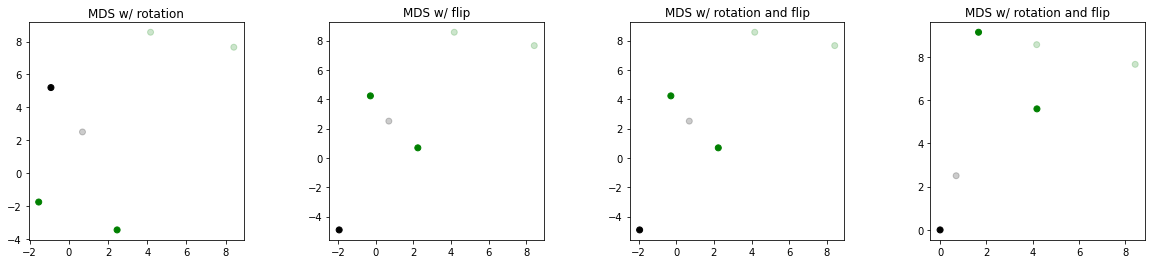

[[-1.94661096 -0.28672194  2.2333329 ]
 [-4.91087302  4.22661869  0.68425433]]
[[0.69285865 8.42088378 4.16954007]
 [2.50523026 7.65365251 8.56386432]]


In [19]:
S2 = rotateMatrix(theta)@Sstar
S3 = rotateMatrix(np.pi)@rotateMatrix(theta+np.pi)@Sstar

fig = plt.figure(3, (20,4))
ax = fig.add_subplot(141)
plt.scatter(Sstar[0,:], Sstar[1,:], color=c_set, alpha=1.0)
plt.scatter(S    [0,:], S    [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ rotation')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(142)
plt.scatter(S2[0,:], S2[1,:], color=c_set, alpha=1.0)
plt.scatter(S [0,:], S [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ flip')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(143)
plt.scatter(S3[0,:], S3[1,:], color=c_set, alpha=1.0)
plt.scatter(S [0,:], S [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ rotation and flip')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(144)
plt.scatter(S3[0,:]-[S3[0,0] for _ in range(n_robots)], S3[1,:]-[S3[1,0] for _ in range(n_robots)], color=c_set, alpha=1.0)
plt.scatter(S [0,:], S [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ rotation and flip')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

print(S2)
print(S)

### Flip and Rotation: Simultaneously

In [20]:
a2 = DM2[0,1] - DMprime[0,1] + deltaX**2 + deltaY**2
b2 = -2*(Sstar[0,1]*deltaX + Sstar[1,1]*deltaY)    
c2 =  2*(Sstar[0,1]*deltaY - Sstar[1,1]*deltaX)    

a3 = DM2[0,2] - DMprime[0,2] + deltaX**2 + deltaY**2
b3 = -2*(Sstar[0,2]*deltaX + Sstar[1,2]*deltaY)     
c3 =  2*(Sstar[0,2]*deltaY - Sstar[1,2]*deltaX)  

Coincise form, as seen on eqs (27) and (28) in the paper

In [21]:
theta11 = theta_i1(Sstar,S,1)
THETA1  = THETA_i (S,[deltaX,deltaY],1)
theta12 = theta_i2(theta11,THETA1)

theta21 = theta_i1(Sstar,S,2)
THETA2  = THETA_i (S,[deltaX,deltaY],2)
theta22 = theta_i2(theta11,THETA2)

print(Sstar)

[[-0.91807496  2.46077206 -1.54269711]
 [ 5.2022213  -3.44834973 -1.75387157]]


If theta11 != theta21, there exists flip

In [22]:
print(theta11,theta21)
print(theta12,theta22)


-1.6887000895735809 None
-1.7840869105013426 -1.0240905619490976


### Implementation without knowing S

In [23]:
theta = estimate_theta(DM2,DMprime,Sstar,[deltaX,deltaY],verbose=1)

After normalization: 
cos(theta):	-0.851442
sin(theta):	-0.524449

theta:	 -2.589525


In [24]:
Sstar_star = rotateMatrix(theta)@Sstar
print(Sstar_star)

[[-1.94661096 -0.28672194  2.2333329 ]
 [-4.91087302  4.22661869  0.68425433]]


In [25]:
deltaX2 = deltaY2 = 0.3

deltaSprime2 = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
deltaSprime2[:,0] = [deltaX2,deltaY2]

Sprime_prime = S + deltaSprime2
print(Sprime_prime)

[[0.99285865 8.42088378 4.16954007]
 [2.80523026 7.65365251 8.56386432]]


In [26]:
DMprime_prime = DM_from_S(Sprime_prime,verbose=1)

theta_R2 = round(estimate_theta(DM2,DMprime_prime, Sstar_star, [deltaX2,deltaY2],verbose=1),2)
theta_R2 = estimate_theta(DM2,DMprime_prime, Sstar_star, [deltaX2,deltaY2],verbose=1)
if theta_R2 == 0.0:
    print("NO FLIP AMBIGUITY. S = S**")

Phi':
 [[  8.8550851 ]
 [129.48968033]
 [ 90.72483645]]
DM' :
 [[ 0.         78.68275566 43.25317107]
 [78.68275566  0.         18.9024089 ]
 [43.25317107 18.9024089   0.        ]]
After normalization: 
cos(theta):	1.000000
sin(theta):	0.000000

theta:	 0.000000
After normalization: 
cos(theta):	1.000000
sin(theta):	0.000000

theta:	 0.000000


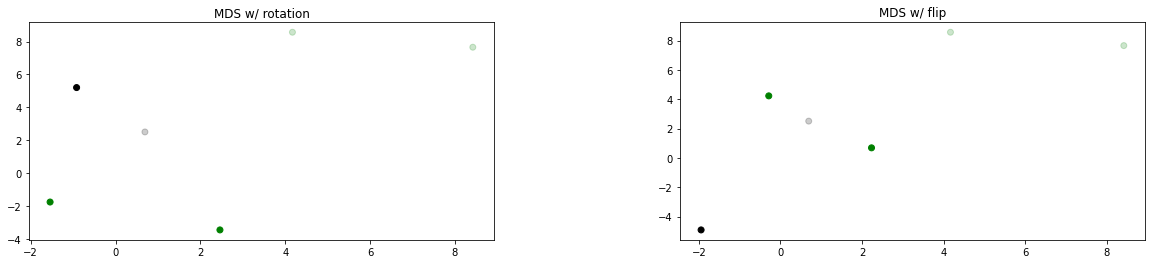

In [27]:
fig = plt.figure(3, (20,4))
ax = fig.add_subplot(121)
plt.scatter(Sstar[0,:], Sstar[1,:], color=c_set, alpha=1.0)
plt.scatter(S    [0,:], S    [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ rotation')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(122)
plt.scatter(Sstar_star[0,:], Sstar_star[1,:], color=c_set, alpha=1.0)
plt.scatter(S         [0,:], S         [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ flip')
fig.subplots_adjust(wspace=.4, hspace=0.5)

plt.show()